In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00a 0:00:01


In [3]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

#data.edge_index has the adj list for the graph

Processing...
Done!


In [4]:
print(len(dataset))

188


In [5]:
train_dataset = dataset[:178]
test_dataset = dataset[178:]

In [6]:
print(len(train_dataset))

178


In [7]:
print(len(test_dataset))

10


In [8]:
dataset = train_dataset

In [9]:
print(len(dataset))

178


In [10]:
print(len(test_dataset))

10


In [11]:
# #using this now
# from torch_geometric.datasets import TUDataset
# from torch_geometric.loader import DataLoader
# import torch


# #load the COLLAB dataset
# dataset = TUDataset(root='/tmp/COLLAB', name='COLLAB')
# print(f"number of graphs: {len(dataset)}")
# print(dataset[0])

# #data.edge_index has the adj list for the graph

In [12]:
for i in range(len(dataset)):
    if dataset[i].x is None:
        dataset[i].x = torch.ones((dataset[i].num_nodes, dataset[0].x.size()[1]))

In [13]:
dataset[0].x.size()[1]

7

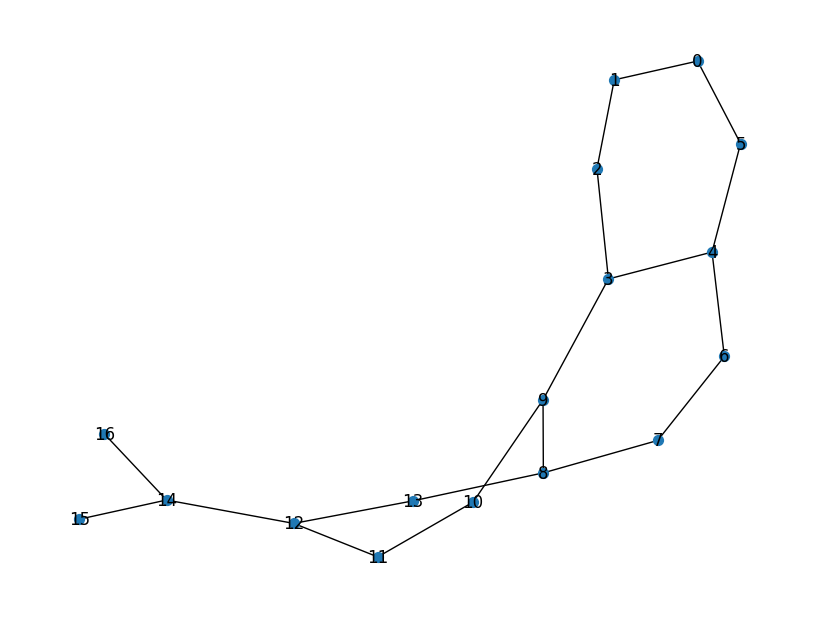

In [14]:
#viz one graph
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

graph = dataset[0]
G = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_size=50)
plt.show()

### implemeting GNN loss here with triplet loss

$$
\mathcal{L} = \max(0, \|z_q - z_{\text{pos}}\|_2^2 - \|z_q - z{\text{neg}}\|_2^2 + \alpha)
$$

### here the idea is to bring zq close to z_pos(positive sample) and get it further from z_neg(negative sample)

In [15]:
from torch_geometric.utils import k_hop_subgraph, subgraph
import torch
import torch.nn.functional as F


def sample_triplet(data, k=2, q_size=4):
    """
    Returns (Gq, Gpos, Gneg) where:
    - Gq is a small query graph,
    - Gpos is a supergraph of Gq,
    - Gneg is a different subgraph not containing Gq.
    """
    anchor_node = torch.randint(0, data.num_nodes, (1,)).item()
    subset_pos, edge_index_pos, _, _ = k_hop_subgraph(anchor_node, k, data.edge_index, relabel_nodes=True)

    if len(subset_pos) < q_size + 1:
        return None

    Gpos = data.subgraph(subset_pos)

    # Sample Gq from within Gpos
    q_nodes = subset_pos[torch.randperm(len(subset_pos))][:q_size]
    Gq = data.subgraph(q_nodes)

    # Sample Gneg from a different anchor node
    neg_anchor = torch.randint(0, data.num_nodes, (1,)).item()
    attempts = 0
    while neg_anchor == anchor_node and attempts < 5:
        neg_anchor = torch.randint(0, data.num_nodes, (1,)).item()
        attempts += 1

    subset_neg, edge_index_neg, _, _ = k_hop_subgraph(neg_anchor, k, data.edge_index, relabel_nodes=True)
    if len(subset_neg) < q_size:
        return None
    Gneg = data.subgraph(subset_neg)

    return Gq, Gpos, Gneg

In [16]:
def triplet_loss(zq, zpos, zneg, alpha=1.0):
    """
    Computes margin-based triplet loss:
        max(0, ||zq - zpos||^2 - ||zq - zneg||^2 + alpha)
    """
    dist_pos = F.pairwise_distance(zq, zpos, p=2)
    dist_neg = F.pairwise_distance(zq, zneg, p=2)
    loss = F.relu(dist_pos - dist_neg + alpha)
    return loss.mean()

In [17]:
#MLP which represents the GIN
#building the GNN model
from torch_geometric.nn import GINConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout

class SubgraphEncoder(torch.nn.Module):
    def __init__(self, in_neurons, hidden_neurons, output_neurons):
        super().__init__()
        nn1 = Sequential(Linear(in_neurons, hidden_neurons),
                         Dropout(0.1),
                         LeakyReLU(1.5),
                         Linear(hidden_neurons, hidden_neurons),
                         ReLU(),
                         Linear(hidden_neurons, hidden_neurons),
                         ReLU(),
                         Linear(hidden_neurons, hidden_neurons))
        #nn1 is really the MLP which is to be trained
        #GINConv() wrapper helps it to apply to all ndoes in the graph 
        #and also apply the loss function 
        self.conv1 = GINConv(nn1)
        self.lin = Linear(hidden_neurons, output_neurons)

    def forward(self, x, edge_index, batch):
        '''
        x: shape of [num_nodes, in_neurons], has the initial features of all nodes for the graph given as input
        edge_index: compressed adj list for the graph given as input
        batch: shape of [num_nodes_in_batch], each entry tells which graph that node belongs to
        '''
        h = self.conv1(x, edge_index)      #passing the graph to a GIN
        h = global_mean_pool(h, batch)
        return F.normalize(self.lin(h), dim=1)   #shape of [num_nodes_in_batch, hidden_neurons]
        #so it contains all the embeddings of all the nodes for all graphs in the mini-batch, and hidden_neurons 
        #is the embedding dimension

In [ ]:
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = SubgraphEncoder(in_neurons=dataset[0].num_features, hidden_neurons=64, output_neurons=16)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

encoder = encoder.to(device)
dataset = [g.to(device) for g in dataset]

epochs = 280
steps_per_epoch = 512

for epoch in range(epochs):
    total_loss = 0

    for _ in range(steps_per_epoch):
        data = random.choice(dataset)

        result = sample_triplet(data)
        if not result:
            continue

        Gq, Gpos, Gneg = result
        Gq.batch = torch.zeros(Gq.num_nodes, dtype=torch.long, device=device)
        Gpos.batch = torch.zeros(Gpos.num_nodes, dtype=torch.long, device=device)
        Gneg.batch = torch.zeros(Gneg.num_nodes, dtype=torch.long, device=device)

        zq = encoder(Gq.x, Gq.edge_index, Gq.batch)
        zpos = encoder(Gpos.x, Gpos.edge_index, Gpos.batch)
        zneg = encoder(Gneg.x, Gneg.edge_index, Gneg.batch)

        loss = triplet_loss(zq.unsqueeze(0), zpos.unsqueeze(0), zneg.unsqueeze(0), alpha=1.0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch}: Triplet Loss = {total_loss:.4f}")

Epoch 0: Triplet Loss = 270.6816
Epoch 1: Triplet Loss = 254.5381
Epoch 2: Triplet Loss = 258.5252
Epoch 3: Triplet Loss = 239.5583
Epoch 4: Triplet Loss = 234.7583
Epoch 5: Triplet Loss = 227.4275
Epoch 6: Triplet Loss = 230.8259
Epoch 7: Triplet Loss = 227.7775
Epoch 8: Triplet Loss = 241.1444
Epoch 9: Triplet Loss = 226.8158
Epoch 10: Triplet Loss = 233.7424
Epoch 11: Triplet Loss = 223.7579
Epoch 12: Triplet Loss = 218.9238
Epoch 13: Triplet Loss = 242.2206
Epoch 14: Triplet Loss = 217.6744
Epoch 15: Triplet Loss = 216.5582
Epoch 16: Triplet Loss = 236.1859
Epoch 17: Triplet Loss = 219.5770
Epoch 18: Triplet Loss = 208.2924
Epoch 19: Triplet Loss = 227.1649
Epoch 20: Triplet Loss = 216.9316
Epoch 21: Triplet Loss = 228.2433
Epoch 22: Triplet Loss = 204.6495
Epoch 23: Triplet Loss = 230.3458
Epoch 24: Triplet Loss = 237.2578
Epoch 25: Triplet Loss = 232.6933
Epoch 26: Triplet Loss = 244.2486
Epoch 27: Triplet Loss = 250.1875
Epoch 28: Triplet Loss = 236.1050
Epoch 29: Triplet Loss =

In [19]:
#saving this model, dont use this later, after saved
torch.save(encoder.state_dict(), 'esm_triplet_loss.pth')

In [20]:
#load the encoder model 
encoder.load_state_dict(torch.load('esm_triplet_loss.pth'))

encoder = encoder.to(device)

#set to evaluation mode if needed
encoder.eval()

SubgraphEncoder(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=1.5)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=64, bias=True)
  ))
  (lin): Linear(in_features=64, out_features=16, bias=True)
)

In [21]:
import torch.nn.functional as F

def subgraph_predict(zq, zu, t):
    """
    Predict whether Gq is a subgraph of Gu using learned embeddings and threshold t.
    """
    diff = F.relu(zq - zu)
    E = torch.norm(diff, p=2, dim=1)
    return (E < t).long()  # 1 if similar (positive), 0 if far (negative)

In [22]:
import numpy as np
from sklearn.metrics import f1_score

def get_embeddings(dataset, device):

    zq_all = []
    zu_all = []
    labels = []

    # Sample 500 positive (Gq, Gpos) and 500 negative (Gq, Gneg) examples
    with torch.no_grad():
        for _ in range(1000):
            data = random.choice(dataset)
    
            result = sample_triplet(data)
            if not result:
                continue
    
            Gq, Gpos, Gneg = result
    
            # Setup batch vectors for each graph
            Gq.batch = torch.zeros(Gq.num_nodes, dtype=torch.long, device=device)
            Gpos.batch = torch.zeros(Gpos.num_nodes, dtype=torch.long, device=device)
            Gneg.batch = torch.zeros(Gneg.num_nodes, dtype=torch.long, device=device)
    
            # Encode embeddings
            zq = encoder(Gq.x, Gq.edge_index, Gq.batch)
            zpos = encoder(Gpos.x, Gpos.edge_index, Gpos.batch)
            zneg = encoder(Gneg.x, Gneg.edge_index, Gneg.batch)
    
            # Append positive pair
            zq_all.append(zq.squeeze(0))
            zu_all.append(zpos.squeeze(0))
            labels.append(1)
    
            # Append negative pair
            zq_all.append(zq.squeeze(0))
            zu_all.append(zneg.squeeze(0))
            labels.append(0)
    
    # Convert to tensors
    zq_all = torch.stack(zq_all)
    zu_all = torch.stack(zu_all)
    labels = torch.tensor(labels, device=device)
    return zq_all, zu_all, labels

In [23]:
zq_all, zu_all, labels = get_embeddings(dataset, device)   #for the training dataset

In [24]:
#find the best t

ts = np.linspace(0, 5, 50)
best_f1 = 0
best_t = 0

for t in ts:
    preds = subgraph_predict(zq_all, zu_all, t)
    f1 = f1_score(labels.cpu(), preds.cpu())
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"Best threshold: {best_t:.2f} with F1-score: {best_f1:.4f}")

Best threshold: 0.41 with F1-score: 0.7533


In [25]:
preds = subgraph_predict(zq_all, zu_all, best_t)
print(preds)

tensor([0, 0, 1,  ..., 0, 1, 0], device='cuda:0')


In [26]:
import torch.nn as nn

MAE = nn.L1Loss()
# compute the mean absolute error
mae = MAE(preds.float(), labels.float())
# print result
print(mae)

tensor(0.2650, device='cuda:0')


In [27]:
print(test_dataset)

MUTAG(10)


In [28]:
#testing on held data
test_dataset = [g.to(device) for g in test_dataset]

zq_all_test, zu_all_test, labels_test = get_embeddings(test_dataset, device)
#dont change best_t, chosen right after training
preds_test = subgraph_predict(zq_all_test, zu_all_test, best_t)
print(preds_test)

tensor([1, 0, 1,  ..., 0, 1, 0], device='cuda:0')


In [29]:
print(labels_test)

tensor([1, 0, 1,  ..., 0, 1, 0], device='cuda:0')


In [30]:
MAE = nn.L1Loss()
mae_test = MAE(preds_test.float(), labels_test.float())
print(mae_test)

tensor(0.3043, device='cuda:0')


In [31]:
print(zq_all_test[0])

tensor([ 0.0024, -0.6050, -0.0031,  0.1534, -0.5703,  0.0464, -0.1585, -0.0392,
         0.1500,  0.0035, -0.0043,  0.0178, -0.4743,  0.0101,  0.0809,  0.0441],
       device='cuda:0')


In [32]:
print(zu_all_test[0])

tensor([ 4.9101e-03, -5.9273e-01,  6.3207e-04,  1.4946e-01, -5.5993e-01,
         1.1168e-02, -1.9184e-01,  7.7384e-03,  1.8194e-01, -5.6505e-04,
        -1.1792e-02, -8.0201e-03, -4.8130e-01, -8.3962e-04,  8.7512e-02,
         5.6393e-02], device='cuda:0')
